<a href="https://colab.research.google.com/github/danzgaming21/G1401221059_Muhammad-Abdan-Rofi/blob/main/Analisis%20Sentimen%20Walikota%20Bekasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# 0) Install & Import Library
# =========================
!pip -q install transformers torch emoji Sastrawi nltk wordcloud unidecode

import pandas as pd
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# =========================
# 1) Load Data
# =========================
from google.colab import files
uploaded = files.upload()  # Pilih Scrap Komentar.csv

FILEPATH = "Scrap Komentar.csv"  # ganti sesuai nama file kamu
df = pd.read_csv(FILEPATH)

print("Kolom:", df.columns)
df.head()


Saving Scrap Komentar.csv to Scrap Komentar (2).csv
Kolom: Index(['tanggal', 'komentar'], dtype='object')


,tanggal,komentar
0,2025-07-30T11:18:42Z,Handa jandan gak bisa melakukannya
1,2025-07-30T03:00:19Z,Pak walikota ini jalanan kota bekasi ko masih ...
2,2025-07-29T04:12:57Z,Dulu menterinya nolak appele i pon 16.. sekara...
3,2025-07-29T04:09:04Z,DULU INDO BLOCK AS.. SEKARANG WAJIB IKUTI APA ...
4,2025-07-28T17:15:41Z,Asallam mu&#39


In [ ]:
# Pastikan nama kolom sesuai
KOMENTAR_COL = "komentar"   # kolom komentar
TANGGAL_COL  = "tanggal"    # kolom tanggal


In [ ]:
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")

Jumlah baris: 491
Jumlah kolom: 2


In [ ]:
# ==== PATCH CEPAT: pastikan komentar_clean ada ====
import re
from unidecode import unidecode
import emoji

# 1) Deteksi kolom komentar kalau variabel KOMENTAR_COL belum/beda
if 'KOMENTAR_COL' not in globals() or KOMENTAR_COL not in df.columns:
    candidates = ["komentar","comment","comments","text","content","isi_komentar","latestComments","textDisplay"]
    KOMENTAR_COL = None
    for c in df.columns:
        if str(c).lower() in candidates:
            KOMENTAR_COL = c
            break
    if KOMENTAR_COL is None:
        raise ValueError(f"Tidak menemukan kolom komentar. Kolom tersedia: {list(df.columns)}")

print("Pakai kolom komentar:", KOMENTAR_COL)

# 2) Jika belum ada komentar_clean, buat sekarang
if "komentar_clean" not in df.columns:
    def emoji_to_words(text):
        t = emoji.demojize(str(text), language='id')
        t = t.replace(":", " ").replace("_", " ")
        t = re.sub(r"\s+", " ", t).strip()
        mapping = {
            r"\bred heart\b": "love",
            r"\bthumbs up\b": "thumbs up",
            r"\bface with tears of joy\b": "laugh",
            r"\bangry face\b": "angry",
            r"\bfire\b": "fire"
        }
        for pat, rep in mapping.items():
            t = re.sub(pat, rep, t)
        return t

    slang_map = {
        "yg":"yang","gk":"nggak","ga":"nggak","gak":"nggak",
        "tdk":"tidak","tp":"tapi","dgn":"dengan","dr":"dari",
        "aja":"saja","krn":"karena","udh":"sudah","sdh":"sudah"
    }
    def normalize_slang(text):
        return " ".join([slang_map.get(w, w) for w in str(text).split()])

    def clean_text(text):
        t = unidecode(str(text))
        t = re.sub(r"http\S+|www\.\S+"," ", t)
        t = re.sub(r"@\w+"," ", t)
        t = re.sub(r"#\w+"," ", t)
        t = emoji_to_words(t)
        t = t.lower()
        t = normalize_slang(t)
        t = re.sub(r"[^a-z0-9\s]"," ", t)
        t = re.sub(r"\s+"," ", t).strip()
        return t

    df["komentar_clean"] = df[KOMENTAR_COL].astype(str).apply(clean_text)

print("Kolom tersedia sekarang:", list(df.columns))
df[["komentar", "komentar_clean"] if "komentar" in df.columns else [KOMENTAR_COL, "komentar_clean"]].head()


Pakai kolom komentar: komentar
Kolom tersedia sekarang: ['tanggal', 'komentar', 'komentar_clean']


,komentar,komentar_clean
0,Handa jandan gak bisa melakukannya,handa jandan nggak bisa melakukannya
1,Pak walikota ini jalanan kota bekasi ko masih ...,pak walikota ini jalanan kota bekasi ko masih ...
2,Dulu menterinya nolak appele i pon 16.. sekara...,dulu menterinya nolak appele i pon 16 sekarang...
3,DULU INDO BLOCK AS.. SEKARANG WAJIB IKUTI APA ...,dulu indo block as sekarang wajib ikuti apa ka...
4,Asallam mu&#39,asallam mu


In [ ]:
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")


Jumlah baris: 491
Jumlah kolom: 3


In [ ]:
# =========================
# D) Prediksi IndoBERT (manual, stabil)
# =========================
MODEL = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
print("Device:", device)

s = df["komentar_clean"].astype(str)
mask_valid = s.str.strip().ne("") & ~s.str.lower().isin(["nan","none","null"])
df_valid = df.loc[mask_valid].copy()
texts = df_valid["komentar_clean"].tolist()

BATCH = 32
labels, scores = [], []
id2label = model.config.id2label

for i in range(0, len(texts), BATCH):
    enc = tokenizer(texts[i:i+BATCH], padding=True, truncation=True, max_length=256, return_tensors="pt")
    enc = {k: v.to(device) for k,v in enc.items()}
    with torch.no_grad():
        out = model(**enc)
        prob = F.softmax(out.logits, dim=-1)
        conf, idx = prob.max(dim=-1)
    labels += [id2label[j.item()] for j in idx]
    scores += conf.detach().cpu().numpy().tolist()

# tempel ke df asli (baris tak-valid tetap ada, hanya NaN di kolom prediksi)
df["sentimen"] = np.nan
df["score"] = np.nan
df.loc[df_valid.index, "sentimen"] = labels
df.loc[df_valid.index, "score"] = scores

print(df["sentimen"].value_counts(dropna=False))


Device: cpu
sentimen
neutral     163
positive    154
negative    131
NaN          43
Name: count, dtype: int64


/tmp/ipython-input-210418493.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'positive', 'negative', 'positive', 'positive', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'negative', 'neutral', 'neutral', 'neutral', 'negative', 'positive', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'positive', 'neutral', 'negative', 'positive', 'positive', 'positive', 'neutral', 'neutral', 'negative', 'positive', 'neutral', 'positive', 'negative', 'negative', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positi

In [ ]:
# =========================
# E) Ringkas & Simpan
# =========================
ringkas = df["sentimen"].value_counts().rename_axis("sentimen").reset_index(name="jumlah")
ringkas["persen"] = (100*ringkas["jumlah"]/ringkas["jumlah"].sum()).round(2)
print(ringkas)

out_cols = [c for c in [TANGGAL_COL, KOMENTAR_COL, "komentar_clean", "sentimen", "score"] if c]
df[out_cols].to_csv("hasil_sentimen_indobert.csv", index=False, encoding="utf-8-sig")
print("✅ Disimpan ke: hasil_sentimen_indobert.csv")


   sentimen  jumlah  persen
0   neutral     163   36.38
1  positive     154   34.38
2  negative     131   29.24
✅ Disimpan ke: hasil_sentimen_indobert.csv


In [ ]:
# 1) Load Data
# ===================================
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df = pd.read_csv("hasil_sentimen_indobert.csv")

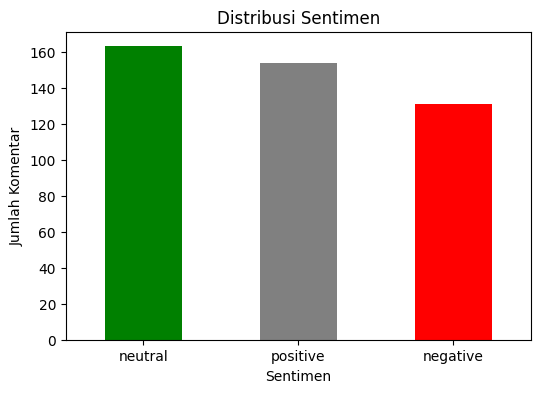

In [ ]:
# 2) Bar Chart Distribusi Sentimen
# ===================================
sent_count = df["sentimen"].value_counts()
plt.figure(figsize=(6,4))
sent_count.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Distribusi Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Komentar")
plt.xticks(rotation=0)
plt.show()


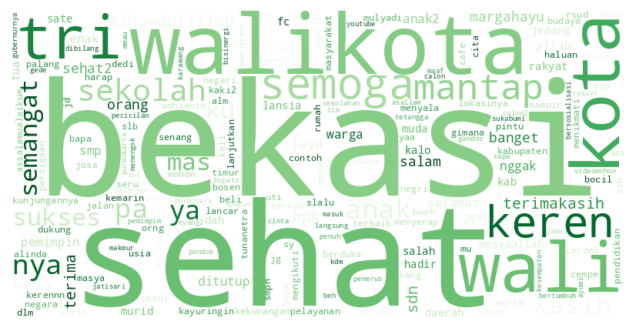

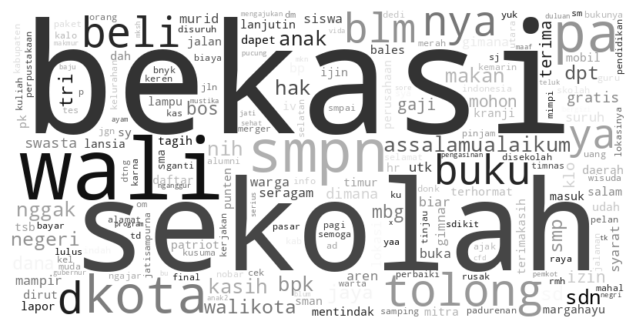

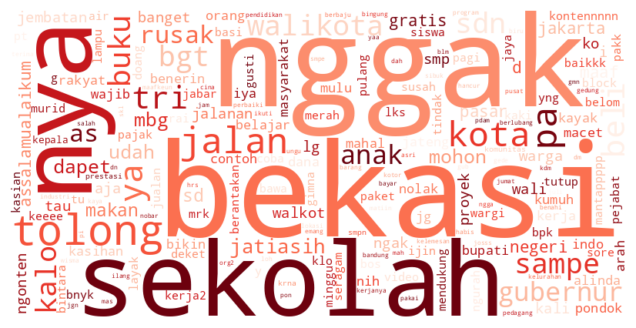

In [ ]:
# 3) Wordcloud per Sentimen
# ===================================
stop_words = set(stopwords.words('indonesian'))

def buat_wordcloud(data, warna):
    text = " ".join([str(k) for k in data if isinstance(k, str)])
    wc = WordCloud(width=800, height=400,
                   background_color="white",
                   colormap=warna,
                   stopwords=stop_words,
                   collocations=False).generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Wordcloud Positif
buat_wordcloud(df[df['sentimen']=='positive']["komentar_clean"], "Greens")

# Wordcloud Netral
buat_wordcloud(df[df['sentimen']=='neutral']["komentar_clean"], "gray")

# Wordcloud Negatif
buat_wordcloud(df[df['sentimen']=='negative']["komentar_clean"], "Reds")

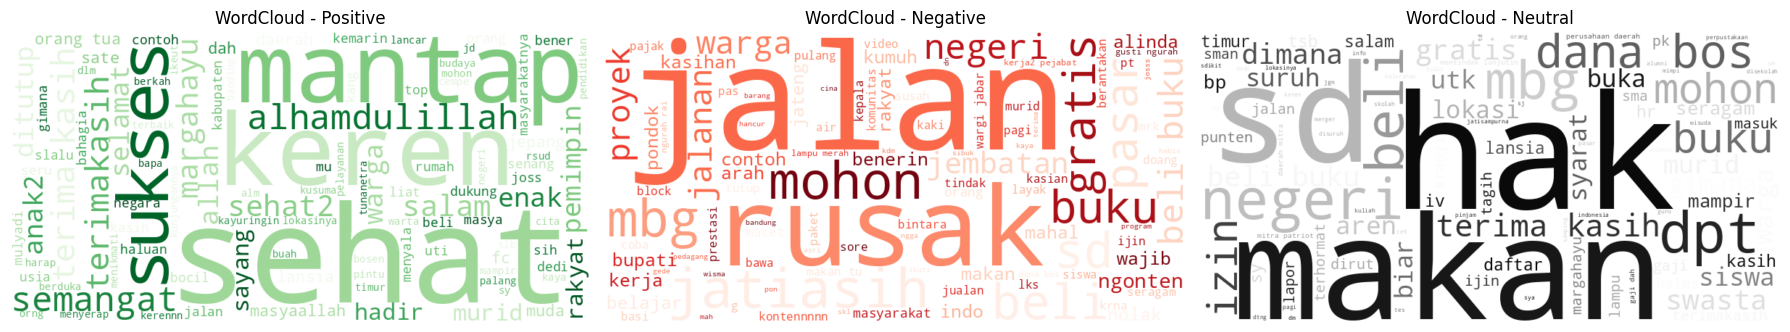

In [175]:

# ========================================
# 2. Stopwords Bahasa Indonesia + Custom
# ========================================
# Stopwords dari NLTK bahasa Indonesia
indo_stopwords = set(stopwords.words('indonesian'))

# Stopwords tambahan khusus dataset kamu
custom_stopwords = {
    "bekasi","walikota","kota","sdn","smp","tri","bpk","ibu","ibuk","bapak","pak","bu",
    "anak","assalamualaikum","tolong","ya","yg","nya","ga","gak","nggak","nih",
    "aja","dong","deh","loh","pun","sebagai","itu","ini","sudah","udah",
    "ke","di","dari","yang","ada","dan","atau","untuk","pada","serta","sekolah","iya","kekurangan","bgt",
    "minggu","gimna","minggu",
    "bgt","pa","dapet","sampe","ko","mantappppp","kali","lg","kalo","y","d","yng","ku","maaf","banget","tau","kalo","kayak","ngak","mulu","wali","semoga","salah",
    "bgt","blm","jg","jakarta","gubernur","walkot","smpn","aamiin","amin","belom","deket","bnyk","keeee","baikkk","mendukung","bikin","jaya","klo","mas","kab","gmna","pakk","kontennnn"
}
# Gabungkan semua stopwords
all_stopwords = STOPWORDS.union(indo_stopwords).union(custom_stopwords)

# ========================================
# 3. Fungsi Plot WordCloud
# ========================================
def plot_wordcloud(text_series, title, color):
    text = " ".join(text_series)
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=all_stopwords,
        colormap=color,
        max_words=100
    ).generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

# ========================================
# 4. Plot WordCloud per Sentimen
# ========================================
sentiments = [
    ('positive', 'Greens'),
    ('negative', 'Reds'),
    ('neutral', 'Greys')
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (senti, color) in zip(axes, sentiments):
    texts = df[df['sentimen_norm'] == senti]['komentar_clean']
    plt.sca(ax)
    plot_wordcloud(texts, f"WordCloud - {senti.capitalize()}", color)

plt.tight_layout()
plt.show()


In [176]:
# ==== LDA untuk komentar POSITIF hasil IndoBERT ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [185]:

# 0) Pilih subset: ganti 'positive' -> 'negative'/'neutral' sesuai kebutuhan
TEXT_COL = "komentar_clean"   # atau "komentar_lda" kalau pakai normalisasi doa
LABEL    = "positive"

texts_all = (df.loc[df["sentimen_norm"]==LABEL, TEXT_COL]
               .dropna().astype(str).tolist())
print(f"{LABEL}: {len(texts_all)} dokumen")

train_txt, valid_txt = train_test_split(texts_all, test_size=0.2, random_state=42, shuffle=True)

# 1) fungsi UMass coherence (tanpa gensim)
def umass_coherence(lda, X, vocab, topn=15, eps=1e-12):
    """
    X: dokumen-term matrix biner (csr_matrix)
    vocab: np.array feature names
    """
    # binarisasi (kemunculan kata di dokumen)
    Xb = X.copy()
    Xb.data[:] = 1

    # frekuensi dokumen per term
    dfreq = np.asarray(Xb.sum(axis=0)).ravel()  # shape [V]
    # precompute co-occurrence (dokumen yang mengandung i & j)
    # gunakan perkalian matriks: Xb.T @ Xb  -> [V x V]
    C = (Xb.T @ Xb).astype(np.float64)  # sangat efisien untuk sparse

    topics = lda.components_
    V = vocab
    K = lda.n_components

    coh_scores = []
    for k in range(K):
        top_idx = topics[k].argsort()[-topn:]  # top terms
        score_k = 0.0; pairs = 0
        # UMass: sum_{i>j} log( (D(w_i, w_j) + eps) / D(w_j) )
        for i_pos in range(1, len(top_idx)):
            wi = top_idx[i_pos]
            for j_pos in range(0, i_pos):
                wj = top_idx[j_pos]
                Dij = C[wi, wj]
                Dj  = dfreq[wj]
                score_k += np.log((Dij + eps) / (Dj + eps))
                pairs += 1
        coh_scores.append(score_k / max(1, pairs))
    # rata-rata coherence seluruh topik
    return float(np.mean(coh_scores))

# 2) grid search
K_LIST      = [3,4,5,6]
MIN_DF_LIST = [3]
MAX_DF_LIST = [0.75]
NGRAMS_LIST = [(1,1),(1,2)]

best = None; tried = 0
history = []

for k in K_LIST:
    for mindf in MIN_DF_LIST:
        for maxdf in MAX_DF_LIST:
            for ngr in NGRAMS_LIST:
                vec = CountVectorizer(
                    min_df=mindf, max_df=maxdf, ngram_range=ngr,
                    stop_words=list(all_stopwords),
                    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b",
                    lowercase=True
                )
                Xtr = vec.fit_transform(train_txt)
                if Xtr.shape[1] == 0:
                    continue
                Xva = vec.transform(valid_txt)

                lda = LatentDirichletAllocation(
                    n_components=k, learning_method="batch",
                    max_iter=60, random_state=42
                ).fit(Xtr)

                # metrik
                perp = lda.perplexity(Xva)  # kecil lebih baik
                # coherence dihitung di TRAIN (umum untuk coherence)
                coh  = umass_coherence(lda, Xtr, vec.get_feature_names_out(), topn=15)

                tried += 1
                history.append({"k":k,"min_df":mindf,"max_df":maxdf,"ngram":ngr,
                                "perplexity":perp, "coherence_umass":coh})

                cand = (perp, -coh, lda, vec, {"k":k,"min_df":mindf,"max_df":maxdf,"ngram":ngr})
                if (best is None) or (cand[0] < best[0]) or (cand[0]==best[0] and cand[1] < best[1]):
                    best = cand

# 3) hasil terbaik + ringkasan
perp, neg_coh, lda_best, vec_best, params = best
terms = np.array(vec_best.get_feature_names_out())
print(f"\n[{LABEL.upper()}] Best params (dicoba {tried} kombinasi): {params} | "
      f"perplexity_valid={perp:.2f} | coherence_umass={-neg_coh:.3f}")

# tampilkan topik
def print_topics(lda, terms, topn=12):
    for t, comp in enumerate(lda.components_):
        top = terms[np.argsort(comp)][-topn:]
        print(f"Topik {t+1}: {', '.join(top)}")

print("\nTopik & kata kunci:")
print_topics(lda_best, terms, topn=12)

positive: 154 dokumen


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'baiknya', 'berkali', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'kurangnya', 'let', 'mata', 'mustn', 'olah', 'sekurang', 'setidak', 'shan', 'shouldn', 'tama', 'tidaknya', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(



[POSITIVE] Best params (dicoba 8 kombinasi): {'k': 3, 'min_df': 3, 'max_df': 0.75, 'ngram': (1, 1)} | perplexity_valid=66.75 | coherence_umass=-22.164

Topik & kata kunci:
Topik 1: keren, mantap, selamat, sukses, enak, sate, terimakasih, terima, kasih, salam, alhamdulillah, sehat
Topik 2: selamat, orang, salam, terima, kasih, masyaallah, rakyat, hadir, allah, sukses, semangat, keren
Topik 3: masyaallah, semangat, sate, salam, terimakasih, kasih, terima, selamat, ditutup, enak, orang, mantap


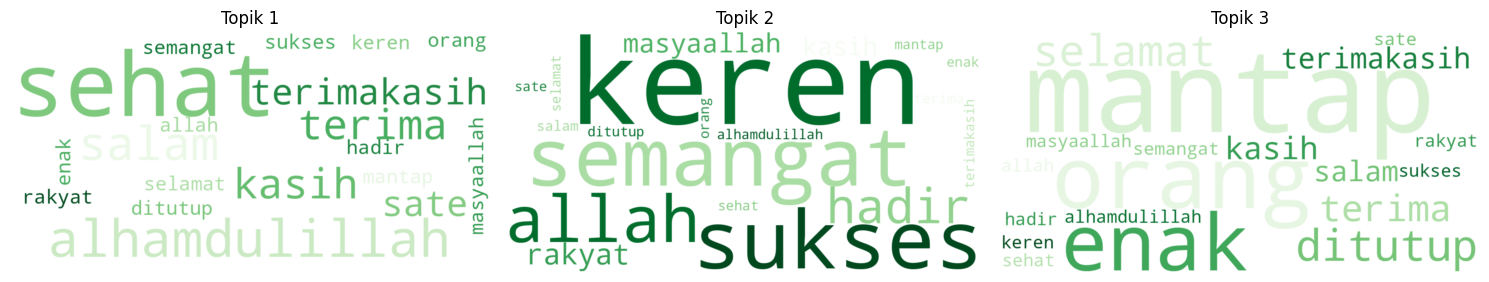

✅ WordCloud disimpan ke folder: lda_positive/


In [186]:
# ================================
# WordCloud per topik + Simpan CSV
# ================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) WordCloud per topik ------------------------------------
label2cmap = {"positive":"Greens","negative":"Reds", "neutral":"Greys"}
cmap = label2cmap.get(LABEL, "Blues")

k = params["k"]
fig, axes = plt.subplots(1, k, figsize=(5*k, 4))
if k == 1: axes = [axes]

# buat folder output
os.makedirs(f"lda_{LABEL}", exist_ok=True)

for i, ax in enumerate(axes):
    comp = lda_best.components_[i]
    # ambil 60 kata teratas untuk wordcloud
    top_idx = comp.argsort()[-60:]
    freq = {terms[j]: float(comp[j]) for j in top_idx}
    wc = WordCloud(width=1200, height=600, background_color="white", colormap=cmap)
    wc = wc.generate_from_frequencies(freq)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Topik {i+1}")
    # simpan juga ke file png
    wc.to_file(f"lda_{LABEL}/wordcloud_topic_{i+1}.png")

plt.tight_layout()
plt.show()
print(f"✅ WordCloud disimpan ke folder: lda_{LABEL}/")

In [188]:

# 0) Pilih subset: ganti 'positive' -> 'negative'/'neutral' sesuai kebutuhan
TEXT_COL = "komentar_clean"   # atau "komentar_lda" kalau pakai normalisasi doa
LABEL    = "negative"

texts_all = (df.loc[df["sentimen_norm"]==LABEL, TEXT_COL]
               .dropna().astype(str).tolist())
print(f"{LABEL}: {len(texts_all)} dokumen")

train_txt, valid_txt = train_test_split(texts_all, test_size=0.2, random_state=42, shuffle=True)

# 1) fungsi UMass coherence (tanpa gensim)
def umass_coherence(lda, X, vocab, topn=15, eps=1e-12):
    """
    X: dokumen-term matrix biner (csr_matrix)
    vocab: np.array feature names
    """
    # binarisasi (kemunculan kata di dokumen)
    Xb = X.copy()
    Xb.data[:] = 1

    # frekuensi dokumen per term
    dfreq = np.asarray(Xb.sum(axis=0)).ravel()  # shape [V]
    # precompute co-occurrence (dokumen yang mengandung i & j)
    # gunakan perkalian matriks: Xb.T @ Xb  -> [V x V]
    C = (Xb.T @ Xb).astype(np.float64)  # sangat efisien untuk sparse

    topics = lda.components_
    V = vocab
    K = lda.n_components

    coh_scores = []
    for k in range(K):
        top_idx = topics[k].argsort()[-topn:]  # top terms
        score_k = 0.0; pairs = 0
        # UMass: sum_{i>j} log( (D(w_i, w_j) + eps) / D(w_j) )
        for i_pos in range(1, len(top_idx)):
            wi = top_idx[i_pos]
            for j_pos in range(0, i_pos):
                wj = top_idx[j_pos]
                Dij = C[wi, wj]
                Dj  = dfreq[wj]
                score_k += np.log((Dij + eps) / (Dj + eps))
                pairs += 1
        coh_scores.append(score_k / max(1, pairs))
    # rata-rata coherence seluruh topik
    return float(np.mean(coh_scores))

# 2) grid search
K_LIST      = [3,4,5,6]
MIN_DF_LIST = [2,3]
MAX_DF_LIST = [0.75]
NGRAMS_LIST = [(1,1),(1,2)]

best = None; tried = 0
history = []

for k in K_LIST:
    for mindf in MIN_DF_LIST:
        for maxdf in MAX_DF_LIST:
            for ngr in NGRAMS_LIST:
                vec = CountVectorizer(
                    min_df=mindf, max_df=maxdf, ngram_range=ngr,
                    stop_words=list(all_stopwords),
                    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b",
                    lowercase=True
                )
                Xtr = vec.fit_transform(train_txt)
                if Xtr.shape[1] == 0:
                    continue
                Xva = vec.transform(valid_txt)

                lda = LatentDirichletAllocation(
                    n_components=k, learning_method="batch",
                    max_iter=60, random_state=42
                ).fit(Xtr)

                # metrik
                perp = lda.perplexity(Xva)  # kecil lebih baik
                # coherence dihitung di TRAIN (umum untuk coherence)
                coh  = umass_coherence(lda, Xtr, vec.get_feature_names_out(), topn=15)

                tried += 1
                history.append({"k":k,"min_df":mindf,"max_df":maxdf,"ngram":ngr,
                                "perplexity":perp, "coherence_umass":coh})

                cand = (perp, -coh, lda, vec, {"k":k,"min_df":mindf,"max_df":maxdf,"ngram":ngr})
                if (best is None) or (cand[0] < best[0]) or (cand[0]==best[0] and cand[1] < best[1]):
                    best = cand

# 3) hasil terbaik + ringkasan
perp, neg_coh, lda_best, vec_best, params = best
terms = np.array(vec_best.get_feature_names_out())
print(f"\n[{LABEL.upper()}] Best params (dicoba {tried} kombinasi): {params} | "
      f"perplexity_valid={perp:.2f} | coherence_umass={-neg_coh:.3f}")

# tampilkan topik
def print_topics(lda, terms, topn=12):
    for t, comp in enumerate(lda.components_):
        top = terms[np.argsort(comp)][-topn:]
        print(f"Topik {t+1}: {', '.join(top)}")

print("\nTopik & kata kunci:")
print_topics(lda_best, terms, topn=12)

negative: 131 dokumen


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'baiknya', 'berkali', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'kurangnya', 'let', 'mata', 'mustn', 'olah', 'sekurang', 'setidak', 'shan', 'shouldn', 'tama', 'tidaknya', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(



[NEGATIVE] Best params (dicoba 16 kombinasi): {'k': 3, 'min_df': 3, 'max_df': 0.75, 'ngram': (1, 1)} | perplexity_valid=3118.61 | coherence_umass=-19.934

Topik & kata kunci:
Topik 1: jabar, pejabat, kontennnnn, mohon, benerin, bupati, jateng, macet, contoh, jembatan, rusak, jalan
Topik 2: coba, nolak, negeri, makan, air, pulang, kumuh, kerja, rakyat, kasihan, pasar, mbg
Topik 3: susah, mahal, ngurah, gusti, rai, paket, negeri, makan, proyek, gratis, beli, buku


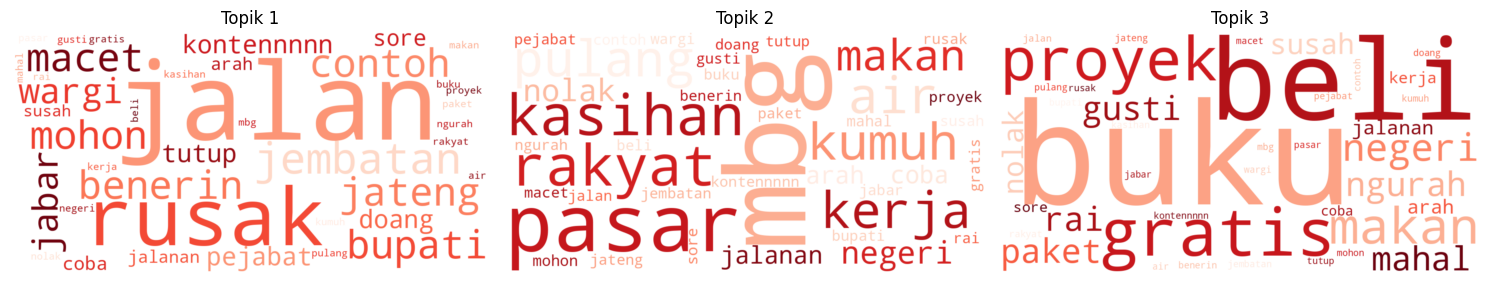

✅ WordCloud disimpan ke folder: lda_negative/


In [189]:
# ================================
# WordCloud per topik + Simpan CSV
# ================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) WordCloud per topik ------------------------------------
label2cmap = {"positive":"Greens","negative":"Reds", "neutral":"Greys"}
cmap = label2cmap.get(LABEL, "Blues")

k = params["k"]
fig, axes = plt.subplots(1, k, figsize=(5*k, 4))
if k == 1: axes = [axes]

# buat folder output
os.makedirs(f"lda_{LABEL}", exist_ok=True)

for i, ax in enumerate(axes):
    comp = lda_best.components_[i]
    # ambil 60 kata teratas untuk wordcloud
    top_idx = comp.argsort()[-60:]
    freq = {terms[j]: float(comp[j]) for j in top_idx}
    wc = WordCloud(width=1200, height=600, background_color="white", colormap=cmap)
    wc = wc.generate_from_frequencies(freq)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Topik {i+1}")
    # simpan juga ke file png
    wc.to_file(f"lda_{LABEL}/wordcloud_topic_{i+1}.png")

plt.tight_layout()
plt.show()
print(f"✅ WordCloud disimpan ke folder: lda_{LABEL}/")

In [190]:

# 0) Pilih subset: ganti 'positive' -> 'negative'/'neutral' sesuai kebutuhan
TEXT_COL = "komentar_clean"   # atau "komentar_lda" kalau pakai normalisasi doa
LABEL    = "neutral"

texts_all = (df.loc[df["sentimen_norm"]==LABEL, TEXT_COL]
               .dropna().astype(str).tolist())
print(f"{LABEL}: {len(texts_all)} dokumen")

train_txt, valid_txt = train_test_split(texts_all, test_size=0.2, random_state=42, shuffle=True)

# 1) fungsi UMass coherence (tanpa gensim)
def umass_coherence(lda, X, vocab, topn=15, eps=1e-12):
    """
    X: dokumen-term matrix biner (csr_matrix)
    vocab: np.array feature names
    """
    # binarisasi (kemunculan kata di dokumen)
    Xb = X.copy()
    Xb.data[:] = 1

    # frekuensi dokumen per term
    dfreq = np.asarray(Xb.sum(axis=0)).ravel()  # shape [V]
    # precompute co-occurrence (dokumen yang mengandung i & j)
    # gunakan perkalian matriks: Xb.T @ Xb  -> [V x V]
    C = (Xb.T @ Xb).astype(np.float64)  # sangat efisien untuk sparse

    topics = lda.components_
    V = vocab
    K = lda.n_components

    coh_scores = []
    for k in range(K):
        top_idx = topics[k].argsort()[-topn:]  # top terms
        score_k = 0.0; pairs = 0
        # UMass: sum_{i>j} log( (D(w_i, w_j) + eps) / D(w_j) )
        for i_pos in range(1, len(top_idx)):
            wi = top_idx[i_pos]
            for j_pos in range(0, i_pos):
                wj = top_idx[j_pos]
                Dij = C[wi, wj]
                Dj  = dfreq[wj]
                score_k += np.log((Dij + eps) / (Dj + eps))
                pairs += 1
        coh_scores.append(score_k / max(1, pairs))
    # rata-rata coherence seluruh topik
    return float(np.mean(coh_scores))

# 2) grid search
K_LIST      = [3,4,5,6]
MIN_DF_LIST = [2,3]
MAX_DF_LIST = [0.75]
NGRAMS_LIST = [(1,1),(1,2)]

best = None; tried = 0
history = []

for k in K_LIST:
    for mindf in MIN_DF_LIST:
        for maxdf in MAX_DF_LIST:
            for ngr in NGRAMS_LIST:
                vec = CountVectorizer(
                    min_df=mindf, max_df=maxdf, ngram_range=ngr,
                    stop_words=list(all_stopwords),
                    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b",
                    lowercase=True
                )
                Xtr = vec.fit_transform(train_txt)
                if Xtr.shape[1] == 0:
                    continue
                Xva = vec.transform(valid_txt)

                lda = LatentDirichletAllocation(
                    n_components=k, learning_method="batch",
                    max_iter=60, random_state=42
                ).fit(Xtr)

                # metrik
                perp = lda.perplexity(Xva)  # kecil lebih baik
                # coherence dihitung di TRAIN (umum untuk coherence)
                coh  = umass_coherence(lda, Xtr, vec.get_feature_names_out(), topn=15)

                tried += 1
                history.append({"k":k,"min_df":mindf,"max_df":maxdf,"ngram":ngr,
                                "perplexity":perp, "coherence_umass":coh})

                cand = (perp, -coh, lda, vec, {"k":k,"min_df":mindf,"max_df":maxdf,"ngram":ngr})
                if (best is None) or (cand[0] < best[0]) or (cand[0]==best[0] and cand[1] < best[1]):
                    best = cand

# 3) hasil terbaik + ringkasan
perp, neg_coh, lda_best, vec_best, params = best
terms = np.array(vec_best.get_feature_names_out())
print(f"\n[{LABEL.upper()}] Best params (dicoba {tried} kombinasi): {params} | "
      f"perplexity_valid={perp:.2f} | coherence_umass={-neg_coh:.3f}")

# tampilkan topik
def print_topics(lda, terms, topn=12):
    for t, comp in enumerate(lda.components_):
        top = terms[np.argsort(comp)][-topn:]
        print(f"Topik {t+1}: {', '.join(top)}")

print("\nTopik & kata kunci:")
print_topics(lda_best, terms, topn=12)

neutral: 163 dokumen


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'baiknya', 'berkali', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'kurangnya', 'let', 'mata', 'mustn', 'olah', 'sekurang', 'setidak', 'shan', 'shouldn', 'tama', 'tidaknya', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(



[NEUTRAL] Best params (dicoba 16 kombinasi): {'k': 3, 'min_df': 3, 'max_df': 0.75, 'ngram': (1, 1)} | perplexity_valid=374.28 | coherence_umass=-22.798

Topik & kata kunci:
Topik 1: jalan, swasta, izin, lampu, aren, buka, mampir, lokasi, negeri, dimana, terima, kasih
Topik 2: jalan, mohon, margahayu, timur, sma, ijin, masuk, biar, gimana, murid, mbg, dpt
Topik 3: negeri, aren, margahayu, utk, salam, gratis, suruh, bos, dana, makan, buku, beli


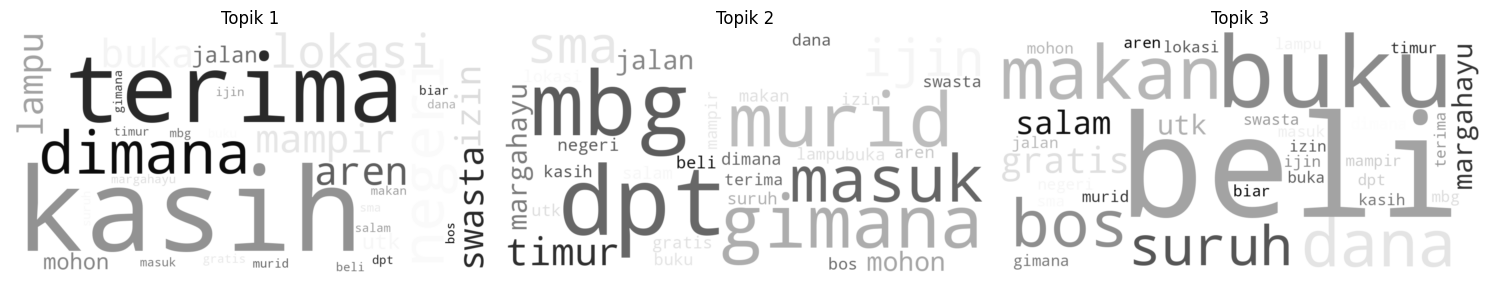

✅ WordCloud disimpan ke folder: lda_neutral/


In [191]:
# ================================
# WordCloud per topik + Simpan CSV
# ================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) WordCloud per topik ------------------------------------
label2cmap = {"positive":"Greens","negative":"Reds", "neutral":"Greys"}
cmap = label2cmap.get(LABEL, "Blues")

k = params["k"]
fig, axes = plt.subplots(1, k, figsize=(5*k, 4))
if k == 1: axes = [axes]

# buat folder output
os.makedirs(f"lda_{LABEL}", exist_ok=True)

for i, ax in enumerate(axes):
    comp = lda_best.components_[i]
    # ambil 60 kata teratas untuk wordcloud
    top_idx = comp.argsort()[-60:]
    freq = {terms[j]: float(comp[j]) for j in top_idx}
    wc = WordCloud(width=1200, height=600, background_color="white", colormap=cmap)
    wc = wc.generate_from_frequencies(freq)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Topik {i+1}")
    # simpan juga ke file png
    wc.to_file(f"lda_{LABEL}/wordcloud_topic_{i+1}.png")

plt.tight_layout()
plt.show()
print(f"✅ WordCloud disimpan ke folder: lda_{LABEL}/")